In [290]:
# imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from datetime import datetime as dt
from haversine import haversine
import plotly.express as px
from keplergl import KeplerGl
import geopandas as gpd
# see all columns
pd.set_option('display.max_columns', None)
# set seaborn style
sns.set_style('whitegrid')
# set context to notebook
sns.set_context('notebook')

In [291]:
# read in data
rentals  =  pd.read_csv('../data/processed/donkey_rentals.csv', parse_dates=["StartTime", "EndTime"])

In [292]:
rentals.head()

,StartTime,EndTime,StartHubId,EndHubId,UserId,latitudeStart,longitudeStart,nameStart,latitudeEnd,longitudeEnd,nameEnd
0,2018-03-01 17:43:14.707445,2018-03-01 18:14:12.145,2163,2449,108186,55.673440,12.564409,Central Station,55.658239,12.605434,Skotlands Plads
1,2018-03-02 09:55:18.823405,2018-03-02 16:56:35.013,2381,2381,113852,55.688937,12.562486,Ravnsborggade,55.688937,12.562486,Ravnsborggade
2,2018-03-02 14:00:10.755516,2018-03-02 17:13:08.047,1513,1513,113912,55.682558,12.580462,Møntergade,55.682558,12.580462,Møntergade
3,2018-03-01 10:25:34.429934,2018-03-02 20:23:46.544,2337,2337,113822,55.670289,12.565058,København H - Bus Stops,55.670289,12.565058,København H - Bus Stops
4,2018-03-02 08:51:47.459257,2018-03-02 21:18:48.813,2153,233,113881,55.680517,12.587455,Nyhavn,55.668475,12.557384,Høkerboderne


In [293]:
rentals.describe()

,StartTime,EndTime,StartHubId,EndHubId,UserId,latitudeStart,longitudeStart,latitudeEnd,longitudeEnd
count,255783,255783,255783.000000,255783.000000,255783.000000,255783.000000,255783.000000,255783.000000,255783.000000
mean,2018-10-18 01:44:09.262078720,2018-10-18 11:09:54.439027456,2978.988619,2993.010333,226931.917180,55.678477,12.567289,55.678432,12.567309
min,2018-03-01 08:12:40.421178,2018-03-01 13:54:47.468000,49.000000,49.000000,1.000000,50.851039,4.401848,50.851039,4.401848
25%,2018-08-01 12:03:19.637252352,2018-08-01 19:52:41.894000128,2179.000000,2180.000000,163366.000000,55.669027,12.551687,55.669265,12.551687
50%,2018-10-06 10:54:50.052364032,2018-10-06 18:56:36.307696128,2428.000000,2431.000000,233749.000000,55.678055,12.568670,55.678067,12.568670
75%,2019-01-18 09:15:01.774339584,2019-01-18 16:17:24.944292608,3659.000000,3688.000000,295462.000000,55.687694,12.584158,55.687694,12.584123
max,2019-04-02 12:39:57.984950,2019-04-02 12:50:41.606215,7419.000000,7419.000000,357161.000000,55.789469,12.650923,55.789469,12.650923
std,NaN,NaN,1482.950197,1482.524948,79492.926788,0.019813,0.031767,0.019920,0.031906


In [294]:
# Check unique values for the categorical columns: NameStart and nameEnd
unique_name_start = rentals['nameStart'].nunique()
unique_name_end = rentals['nameEnd'].nunique()

unique_name_start, unique_name_end

(1185, 1168)

In [295]:
# Check for rentals that start and end in the same hub
same_hub_rentals = rentals[rentals['StartHubId'] == rentals['EndHubId']]

# Count the number of such rentals
same_hub_rentals_count = same_hub_rentals.shape[0]

same_hub_rentals_count

61050

In [296]:
# Calculate the haversine distance between the starting and ending points
def calculate_distance(row):
    start_coords = (row['latitudeStart'], row['longitudeStart'])
    end_coords = (row['latitudeEnd'], row['longitudeEnd'])
    return haversine(start_coords, end_coords)

rentals['HaversineDistance'] = rentals.apply(calculate_distance, axis=1)

In [297]:
# Extract Month, Day, and StartHour from the StartTime column again
rentals['Month'] = rentals['StartTime'].dt.month_name()
rentals['StartHour'] = rentals['StartTime'].dt.hour

# Add the 'Weekday' column as a string
rentals['Weekday'] = rentals['StartTime'].dt.day_name()
# Calculate the rental duration in minutes
rentals['TripDurationMin'] = (rentals['EndTime'] - rentals['StartTime']).dt.total_seconds() / 60
# create a new column for trip duration in hours
rentals['TripDurationHr'] = rentals['TripDurationMin'] / 60

# create speed column in km/hr based on trip duration and average bike speed of a person
rentals['SpeedKmHr'] = 3.1 / rentals['TripDurationHr']

In [298]:
# describe the TripDurationMin column
rentals['TripDurationMin'].describe()

count    255783.000000
mean        565.752949
std        1552.825657
min       -1361.486435
25%          25.790993
50%         220.745106
75%         591.696032
max      126554.987580
Name: TripDurationMin, dtype: float64

In [299]:
# drop the rentals with negative duration
rentals = rentals[rentals['TripDurationMin'] > 1]

In [300]:
# Calculate the IQR for TripDurationMin
Q1 = rentals['TripDurationMin'].quantile(0.25)
Q3 = rentals['TripDurationMin'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outlier trips
outlier_trips = rentals[(rentals['TripDurationMin'] < lower_bound) | (rentals['TripDurationMin'] > upper_bound)]

# Display basic statistics of outlier durations and the first few rows of outlier trips
outlier_statistics = outlier_trips['TripDurationMin'].describe()

In [301]:
outlier_statistics

count     19165.000000
mean       3755.442707
std        4423.182635
min        1442.610004
25%        1998.081537
50%        2826.807031
75%        4081.488476
max      126554.987580
Name: TripDurationMin, dtype: float64

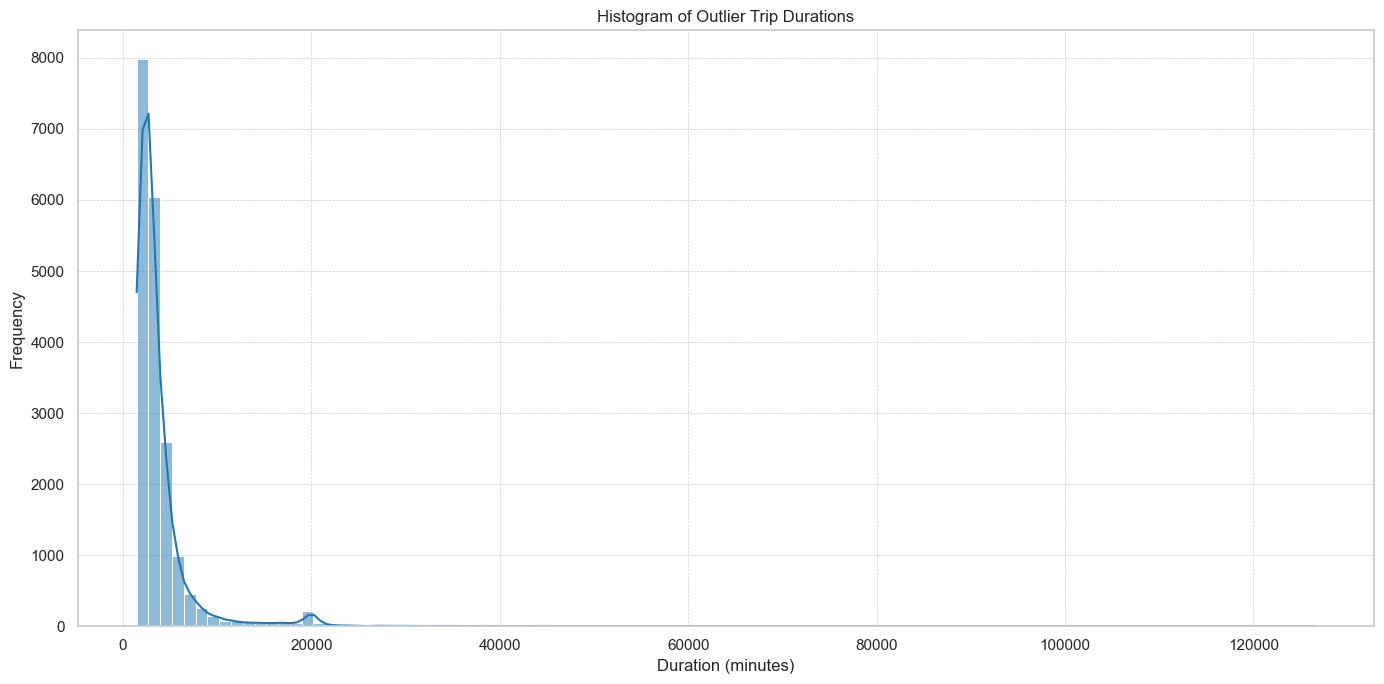

In [302]:
# Plotting a histogram for outlier trip durations
plt.figure(figsize=(14, 7))
sns.histplot(outlier_trips['TripDurationMin'], bins=100, kde=True)
plt.title('Histogram of Outlier Trip Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [303]:
# Calculate the number of days for each outlier trip
outlier_trips['Days'] = outlier_trips['TripDurationMin'] // 1440  # There are 1440 minutes in a day

# Count the number of trips for each day span
days_distribution = outlier_trips['Days'].value_counts().sort_index()

days_distribution


C:\Users\mihai\AppData\Local\Temp\ipykernel_23588\3353563448.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Days
1.0     11225
2.0      4409
3.0      1639
4.0       631
5.0       353
6.0       171
7.0       106
8.0        66
9.0        60
10.0       51
11.0       50
12.0       52
13.0      190
14.0       69
15.0       14
16.0       10
17.0        3
18.0        6
19.0        3
20.0        4
21.0        3
22.0        3
23.0        2
24.0        3
25.0        2
26.0        3
28.0        1
29.0        2
30.0        4
31.0        2
33.0        2
36.0        1
37.0        1
38.0        1
41.0        2
42.0        2
44.0        1
45.0        1
46.0        3
49.0        1
50.0        1
57.0        1
58.0        1
61.0        2
62.0        1
63.0        1
64.0        1
65.0        1
76.0        1
84.0        1
87.0        2
Name: count, dtype: int64

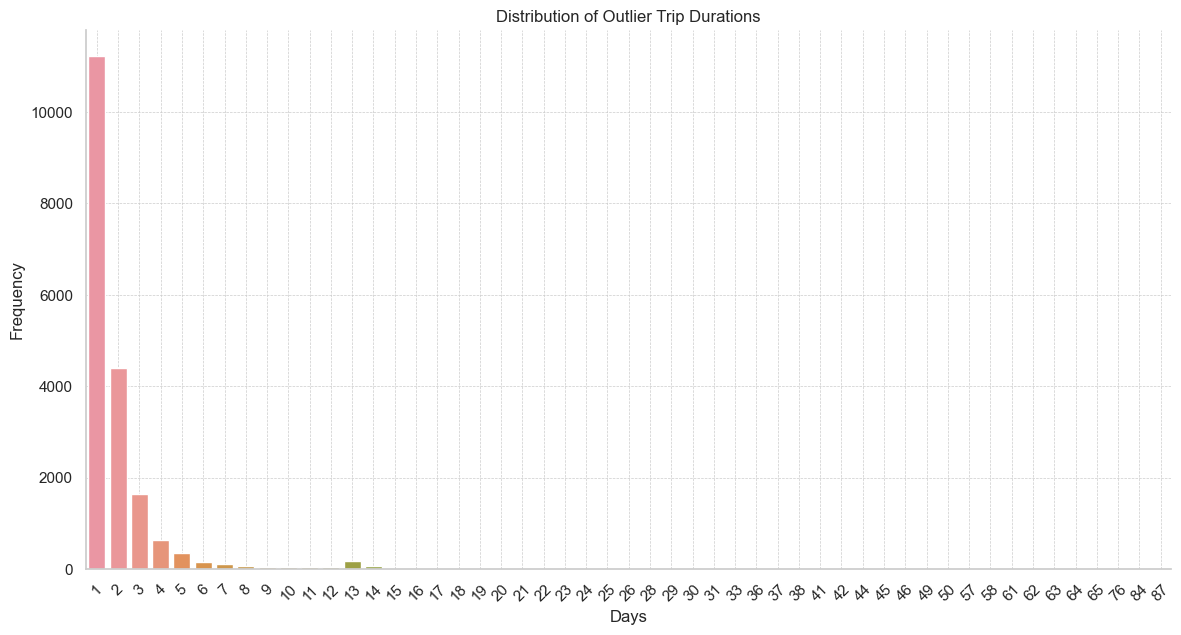

In [304]:
# plot the days_distribution
plt.figure(figsize=(14, 7))
sns.barplot(x=days_distribution.index.astype(np.int64), y=days_distribution.values)
plt.title('Distribution of Outlier Trip Durations')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
sns.despine()
plt.show()


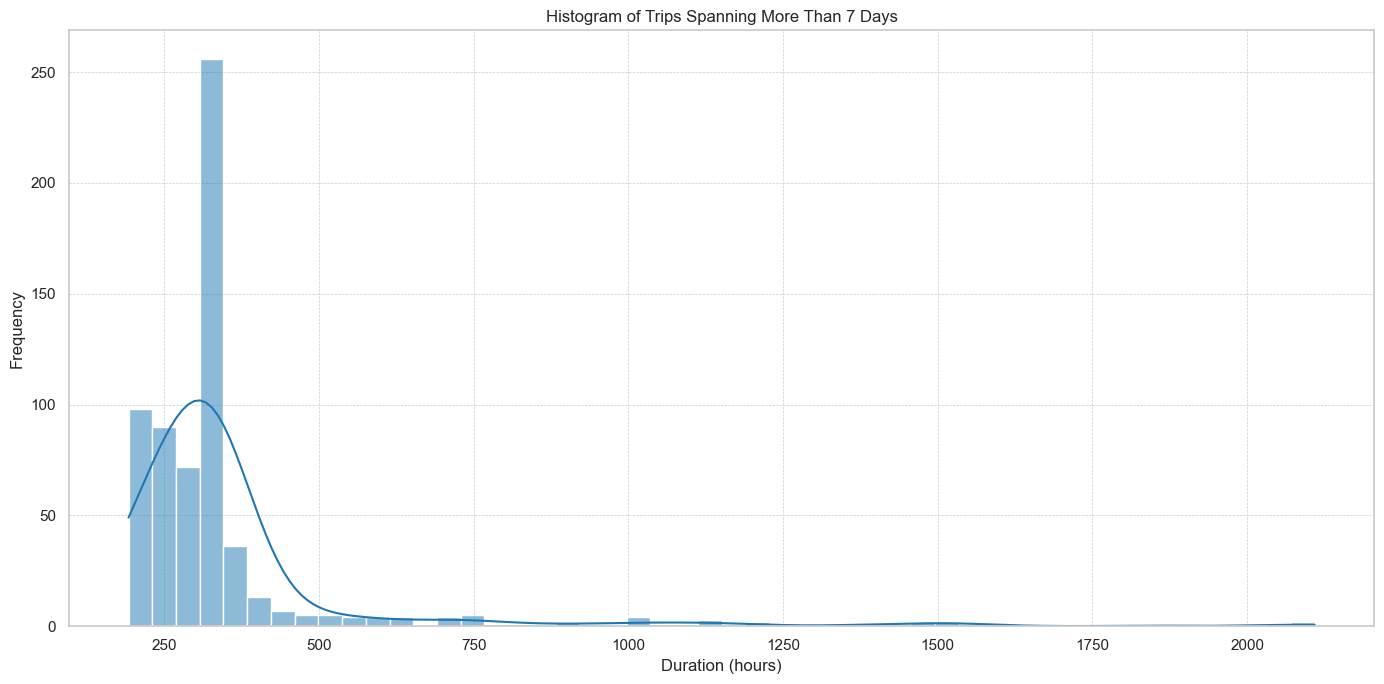

In [305]:
# Filter trips that span more than 7 days
long_duration_trips = outlier_trips[outlier_trips['Days'] > 7]

# Plotting a histogram for these long-duration trips
plt.figure(figsize=(14, 7))
sns.histplot(long_duration_trips['TripDurationHr'], bins=50, kde=True)
plt.title('Histogram of Trips Spanning More Than 7 Days')
plt.xlabel('Duration (hours)')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [306]:
len(long_duration_trips)

631

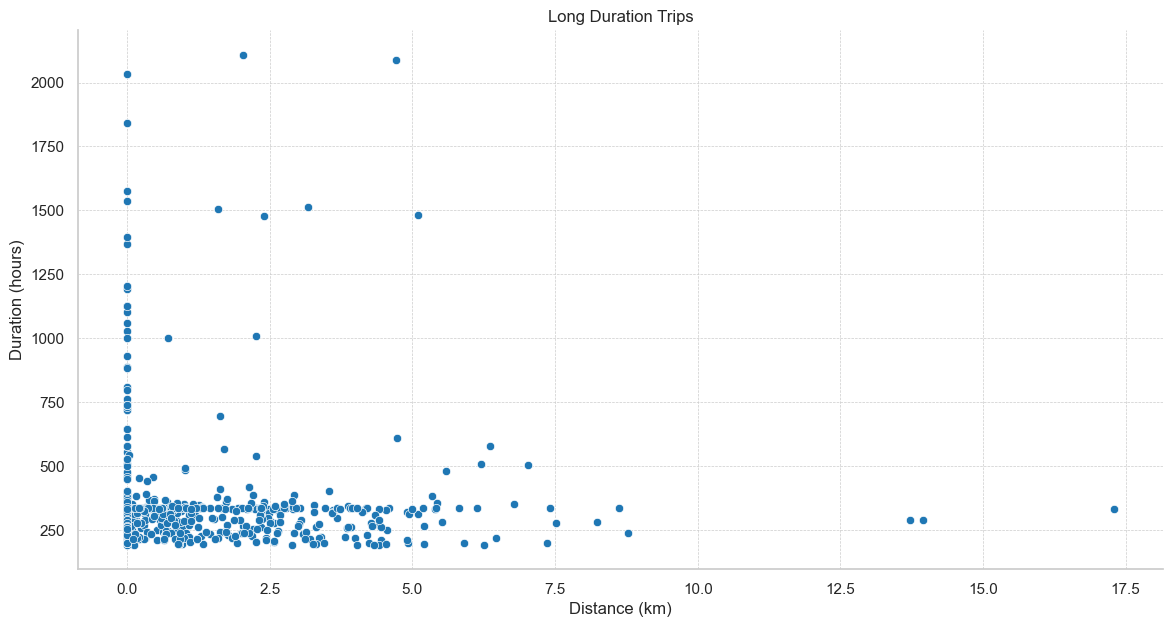

In [307]:
# scatter plot of the long duration in hours vs. the haversine distance
plt.figure(figsize=(14, 7))
sns.scatterplot(x=long_duration_trips['HaversineDistance'], y=long_duration_trips['TripDurationHr'])
plt.title('Long Duration Trips')
plt.xlabel('Distance (km)')
plt.ylabel('Duration (hours)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine()
plt.show()

In [308]:
# print the row of the top 10 longest trips
outlier_trips.sort_values('TripDurationMin', ascending=False).head(10)


,StartTime,EndTime,StartHubId,EndHubId,UserId,latitudeStart,longitudeStart,nameStart,latitudeEnd,longitudeEnd,nameEnd,HaversineDistance,Month,StartHour,Weekday,TripDurationMin,TripDurationHr,SpeedKmHr,Days
60462,2018-05-19 11:02:20.807840,2018-08-15 08:17:20.062634,2284,2449,144681,55.669027,12.579419,Ved Langebro,55.658239,12.605434,Skotlands Plads,2.025133,May,11,Saturday,126554.987580,2109.249793,0.001470,87.0
60463,2018-05-20 08:12:31.631738,2018-08-15 08:17:50.286699,2104,2797,14336,55.667553,12.553189,Litauens Plads,55.709616,12.561689,Sejrøgade,4.707382,May,8,Sunday,125285.310916,2088.088515,0.001485,87.0
26751,2018-04-21 16:35:03.195582,2018-07-15 11:16:49.206618,1886,1886,128376,55.704832,12.537932,Lygten,55.704832,12.537932,Lygten,0.000000,April,16,Saturday,122081.766851,2034.696114,0.001524,84.0
176890,2018-10-22 17:31:23.553629,2019-01-07 13:08:53.611385,4719,4719,267762,55.662698,12.563152,Havnebadet Fisketorvet,55.662698,12.563152,Havnebadet Fisketorvet,0.000000,October,17,Monday,110617.500963,1843.625016,0.001681,76.0
210795,2018-11-02 20:01:57.172792,2019-01-07 13:07:42.627135,5501,5501,303464,55.645486,12.522782,Valbyparken,55.645486,12.522782,Valbyparken,0.000000,November,20,Friday,94625.757572,1577.095960,0.001966,65.0
191764,2018-11-04 12:01:46.816979,2019-01-07 13:06:47.781957,1520,1520,304824,55.677285,12.577430,Gammel Strand,55.677285,12.577430,Gammel Strand,0.000000,November,12,Sunday,92225.016083,1537.083601,0.002017,64.0
116802,2018-07-14 20:39:10.951053,2018-09-15 22:29:51.716007,3507,2190,197543,55.693762,12.541943,Nørrebroparken,55.670371,12.570705,Politigården,3.164771,July,20,Saturday,90830.679416,1513.844657,0.002048,63.0
73170,2018-06-06 15:55:44.900122,2018-08-08 10:06:30.816852,2227,2251,146042,55.672581,12.573892,Ny Carlsberg Glyptotek,55.677731,12.597614,3-Way Bridge,1.593844,June,15,Wednesday,90370.765279,1506.179421,0.002058,62.0
190255,2018-10-27 14:27:19.846342,2018-12-28 09:54:13.154223,5249,3039,224781,55.659138,12.519597,Trekronergade,55.703422,12.541014,Mimersparken,5.103897,October,14,Saturday,89006.888465,1483.448141,0.002090,61.0
40564,2018-04-21 16:35:03.220640,2018-06-22 08:30:52.983862,1886,937,128380,55.704832,12.537932,Lygten,55.685091,12.553199,Åboulevard,2.394533,April,16,Saturday,88795.829387,1479.930490,0.002095,61.0


In [309]:
# Calculate the number of trips lasting more than 2 weeks (14 days)
two_weeks_minutes = 14 * 24 * 60
long_trips_count = len(rentals[rentals['TripDurationMin'] > two_weeks_minutes])

# Calculate the percentage of these trips compared to the entire dataset
percentage_long_trips = (long_trips_count / len(rentals)) * 100

long_trips_count, percentage_long_trips


(162, 0.06347514673729909)

In [310]:
# create boolean column called RoundTrip
rentals['RoundTrip'] = rentals['StartHubId'] == rentals['EndHubId']


In [312]:
rentals.head()

,StartTime,EndTime,StartHubId,EndHubId,UserId,latitudeStart,longitudeStart,nameStart,latitudeEnd,longitudeEnd,nameEnd,HaversineDistance,Month,StartHour,Weekday,TripDurationMin,TripDurationHr,SpeedKmHr,RoundTrip
0,2018-03-01 17:43:14.707445,2018-03-01 18:14:12.145,2163,2449,108186,55.673440,12.564409,Central Station,55.658239,12.605434,Skotlands Plads,3.078446,March,17,Thursday,30.957293,0.515955,6.008277,False
1,2018-03-02 09:55:18.823405,2018-03-02 16:56:35.013,2381,2381,113852,55.688937,12.562486,Ravnsborggade,55.688937,12.562486,Ravnsborggade,0.000000,March,9,Friday,421.269827,7.021164,0.441522,True
2,2018-03-02 14:00:10.755516,2018-03-02 17:13:08.047,1513,1513,113912,55.682558,12.580462,Møntergade,55.682558,12.580462,Møntergade,0.000000,March,14,Friday,192.954858,3.215914,0.963956,True
3,2018-03-01 10:25:34.429934,2018-03-02 20:23:46.544,2337,2337,113822,55.670289,12.565058,København H - Bus Stops,55.670289,12.565058,København H - Bus Stops,0.000000,March,10,Thursday,2038.201901,33.970032,0.091257,True
4,2018-03-02 08:51:47.459257,2018-03-02 21:18:48.813,2153,233,113881,55.680517,12.587455,Nyhavn,55.668475,12.557384,Høkerboderne,2.312564,March,8,Friday,747.022562,12.450376,0.248988,False


In [313]:
rentals.RoundTrip.value_counts(normalize=True)

RoundTrip
False    0.762948
True     0.237052
Name: proportion, dtype: float64

In [318]:
# calculate nr and percentage of trips longer than 2, 6, 12, 24 hours
# use TripDurationHr column
trip_durations = [3, 9, 16, 24]
trip_counts = []
trip_percentages = []

for duration in trip_durations:
    trips = rentals[rentals['TripDurationHr'] < duration]
    trip_count = len(trips)
    trip_percentage = (trip_count / len(rentals)) * 100
    trip_counts.append(trip_count)
    trip_percentages.append(trip_percentage)
    print(f"Number of trips shorter than {duration} hours: {trip_count}, Percentage: {trip_percentage:.2f}%")



Number of trips shorter than 3 hours: 120388, Percentage: 47.17%
Number of trips shorter than 9 hours: 182759, Percentage: 71.61%
Number of trips shorter than 16 hours: 219923, Percentage: 86.17%
Number of trips shorter than 24 hours: 235815, Percentage: 92.40%


In [ ]:
# Drop trips lasting more than 2 weeks
rentals= rentals[rentals['TripDurationMin'] <= two_weeks_minutes]

# Confirm the removal
remaining_long_trips_count = len(rentals[rentals['TripDurationMin'] > two_weeks_minutes])
remaining_long_trips_count


0

# Trips less than 12h


In [ ]:
# drop trips lasting more than 12 hours
rentals = rentals[rentals['TripDurationHr'] <= 2]

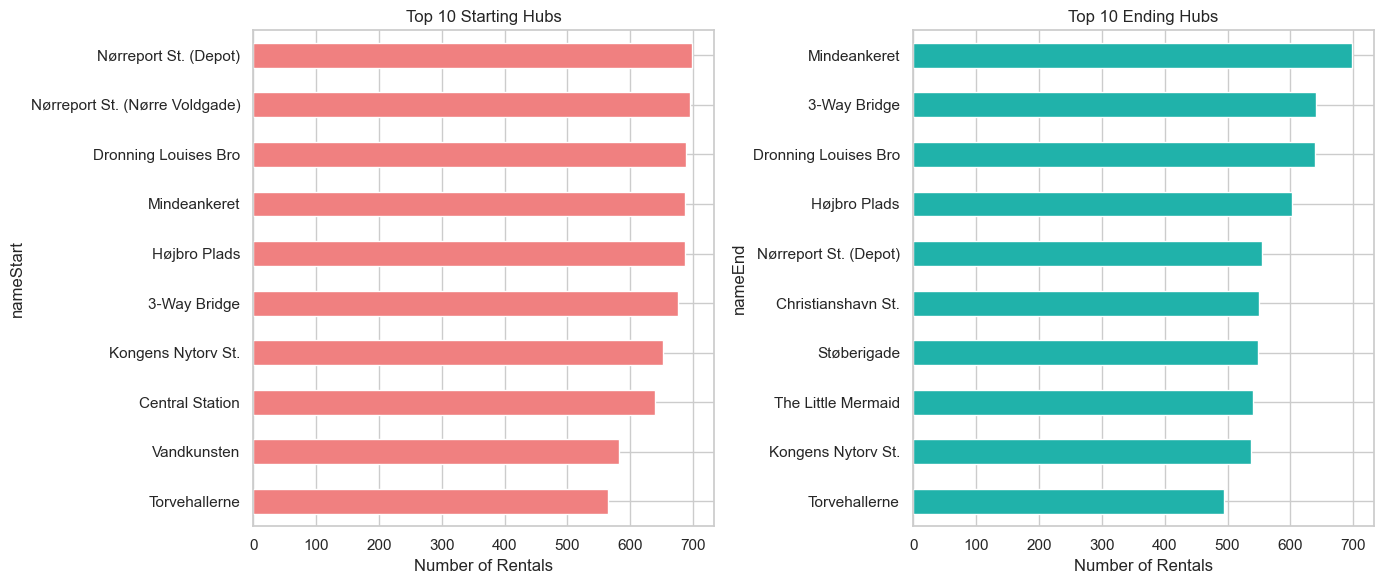

In [ ]:
# Top 10 hubs for starting rentals
top_start_hubs = rentals['nameStart'].value_counts().head(10)

# Top 10 hubs for ending rentals
top_end_hubs = rentals['nameEnd'].value_counts().head(10)

plt.figure(figsize=(14, 6))

# Plotting top starting hubs
plt.subplot(1, 2, 1)
top_start_hubs.plot(kind='barh', color='lightcoral')
plt.title('Top 10 Starting Hubs')
plt.xlabel('Number of Rentals')
plt.gca().invert_yaxis()  # To have the hub with the highest count at the top

# Plotting top ending hubs
plt.subplot(1, 2, 2)
top_end_hubs.plot(kind='barh', color='lightseagreen')
plt.title('Top 10 Ending Hubs')
plt.xlabel('Number of Rentals')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


c:\ProgramData\anaconda3\envs\thesis\Lib\site-packages\seaborn\_oldcore.py:1599: UserWarning:

Vertical orientation ignored with only `x` specified.



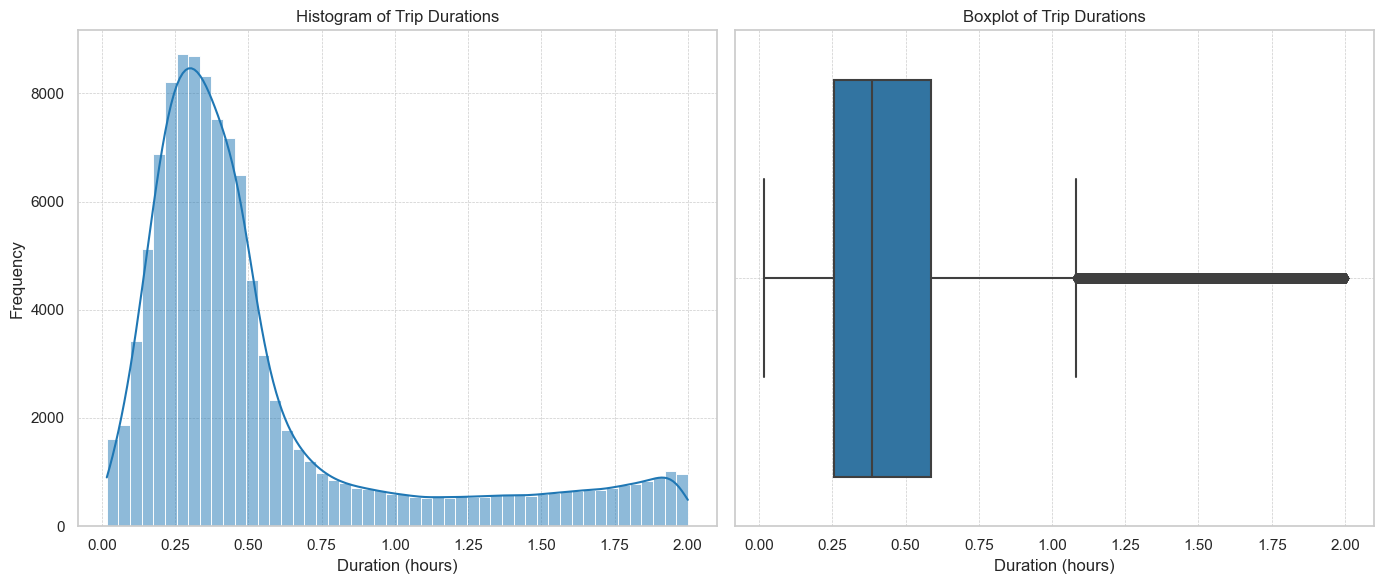

In [ ]:
# plot the distribution of the TripDurationHr column using a histogram and a boxplot using subplots

plt.figure(figsize=(14, 6))

# Plotting a histogram
plt.subplot(1, 2, 1)
sns.histplot(rentals['TripDurationHr'], bins=50, kde=True)
plt.title('Histogram of Trip Durations')
plt.xlabel('Duration (hours)')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plotting a boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=rentals['TripDurationHr'], orient='v')
plt.title('Boxplot of Trip Durations')
plt.xlabel('Duration (hours)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()




In [ ]:
# Create a combined column representing the route as "StartHub -> EndHub"
rentals['Route'] = rentals['nameStart'] + " -> " + rentals['nameEnd']

# Identify the top 10 most popular routes
top_routes = rentals['Route'].value_counts().head(20)

top_routes


Route
Strandlodsvej -> Strandlodsvej                                      103
Grønjordskollegiet -> Grønjordskollegiet                            100
Otto Baches Alle -> Otto Baches Alle                                 98
Vandkunsten -> Vandkunsten                                           93
Bryghusgade -> Bryghusgade                                           91
Tycho Brahe Planetarium -> Tycho Brahe Planetarium                   86
Vesterbrogade / Saxogade -> Copenhagen University Panum              81
Jarmers Tårn -> Jarmers Tårn                                         74
Central Station -> Central Station                                   71
Founders House -> Founders House                                     69
Nørreport St. (Nørre Voldgade) -> Nørreport St. (Nørre Voldgade)     69
Ny Carlsberg Glyptotek -> Ny Carlsberg Glyptotek                     66
Højbro Plads -> Højbro Plads                                         63
Christianshavn St. -> Christianshavn St.                  

In [ ]:
# for each value in top_routes, get the average trip duration
avg_durations = []
for route in top_routes:
    avg_duration = rentals[rentals['Route'] == route]['TripDurationHr'].mean()
    avg_durations.append(avg_duration)

In [ ]:
# for each top route, calculate the average trip duration
top_routes_duration = rentals.groupby('Route').aggregate({'TripDurationHr': 'mean'}).sort_values('TripDurationHr', ascending=False).head(20)

In [ ]:
top_routes_duration

,TripDurationHr
Route,
Hammerensgade -> Sønder Blvd.,1.999749
Stormbroen -> Badstuestræde,1.999235
Holmens Kanal -> Nyhavn,1.999216
Silkegade -> Dronningens Tværgade,1.999166
Rådhuspladsen II -> Gammel Strand,1.999022
Høkerboderne -> Skabelonloftet,1.998951
Superkilen Park -> Minebådsgraven - Refshalevej,1.998660
Buddinge Station -> Helgolandsgade,1.998649
Reventlowsgade -> Regnbuepladsen,1.998608


In [ ]:
rentals.StartHour.value_counts().sort_index()

StartHour
0     1510
1     1248
2      912
3      613
4      634
5     1758
6     4598
7     5959
8     5460
9     5899
10    6141
11    5856
12    6197
13    6765
14    8012
15    9112
16    8745
17    7162
18    5730
19    5090
20    4209
21    3667
22    2803
23    2133
Name: count, dtype: int64

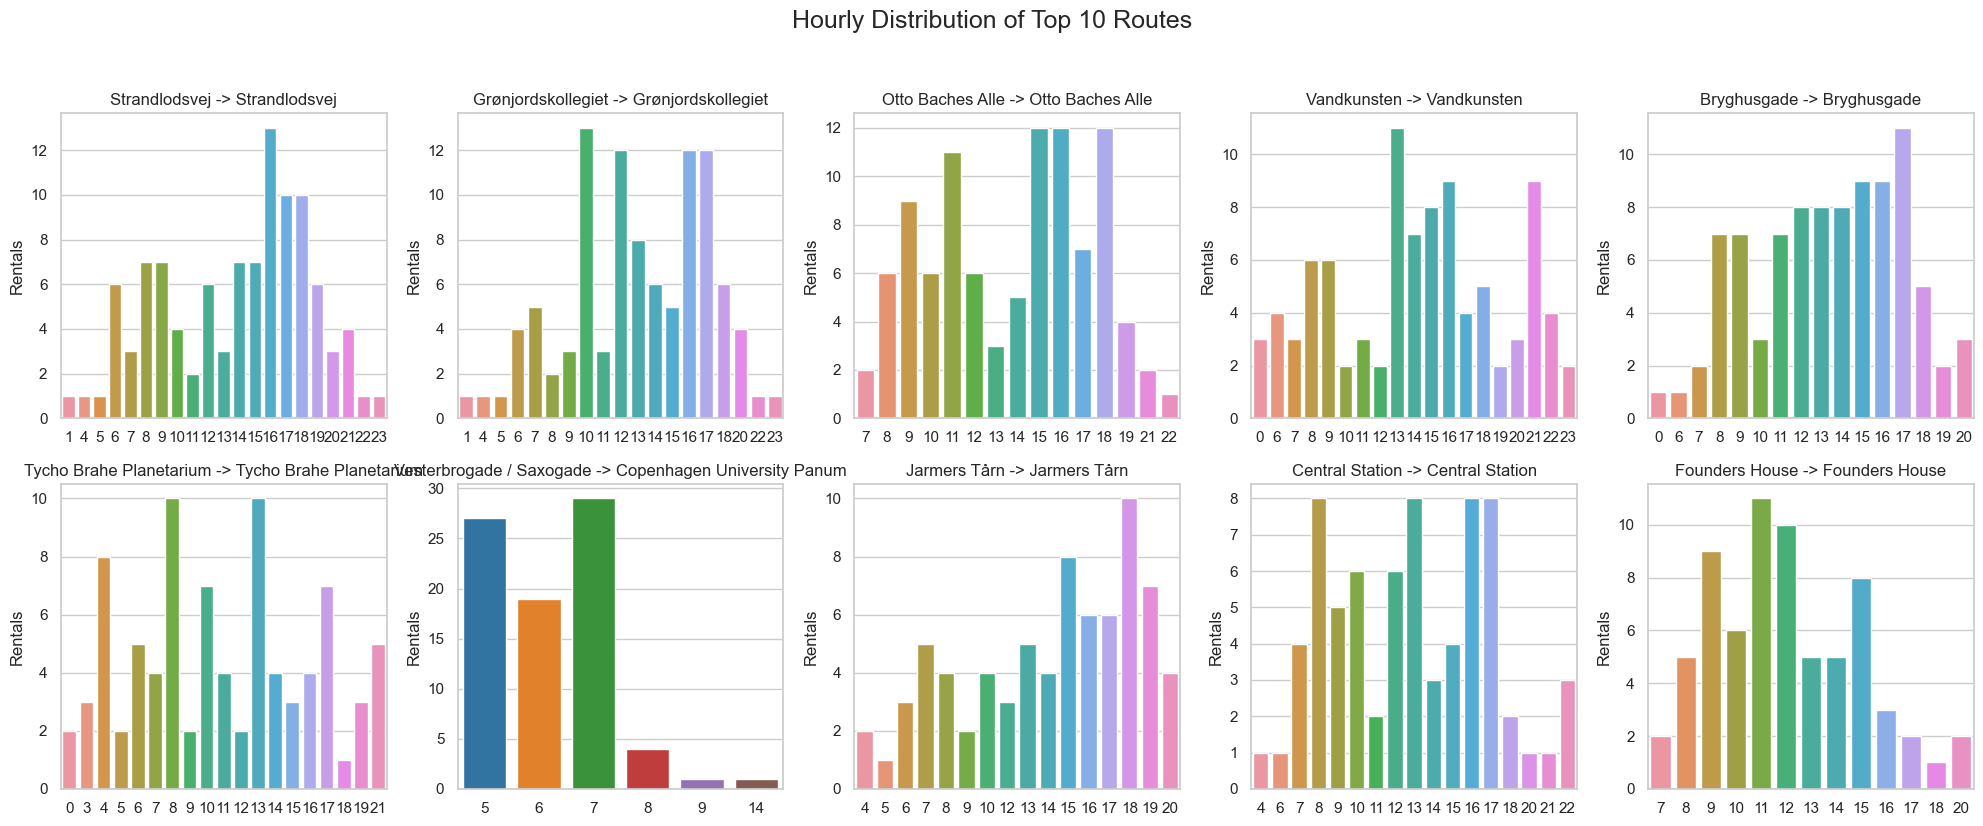

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a list of the top 10 most popular routes
top_routes = rentals['Route'].value_counts().head(10).index
top_routes_series = rentals['Route'].value_counts().head(10)

# Create a figure with 5 columns and 2 rows
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# Flatten the axes array
axes = axes.flatten()

# Loop through the top 10 routes and create a countplot for each one
for i, route in enumerate(top_routes):
    route_rentals = rentals[rentals['Route'] == route]
    sns.countplot(x='StartHour', data=route_rentals, ax=axes[i])
    axes[i].set_title(route)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Rentals')

plt.suptitle('Hourly Distribution of Top 10 Routes', y=1.03, fontsize=18)
plt.tight_layout()
plt.show()


In [ ]:
top_routes_series

Route
Strandlodsvej -> Strandlodsvej                             103
Grønjordskollegiet -> Grønjordskollegiet                   100
Otto Baches Alle -> Otto Baches Alle                        98
Vandkunsten -> Vandkunsten                                  93
Bryghusgade -> Bryghusgade                                  91
Tycho Brahe Planetarium -> Tycho Brahe Planetarium          86
Vesterbrogade / Saxogade -> Copenhagen University Panum     81
Jarmers Tårn -> Jarmers Tårn                                74
Central Station -> Central Station                          71
Founders House -> Founders House                            69
Name: count, dtype: int64

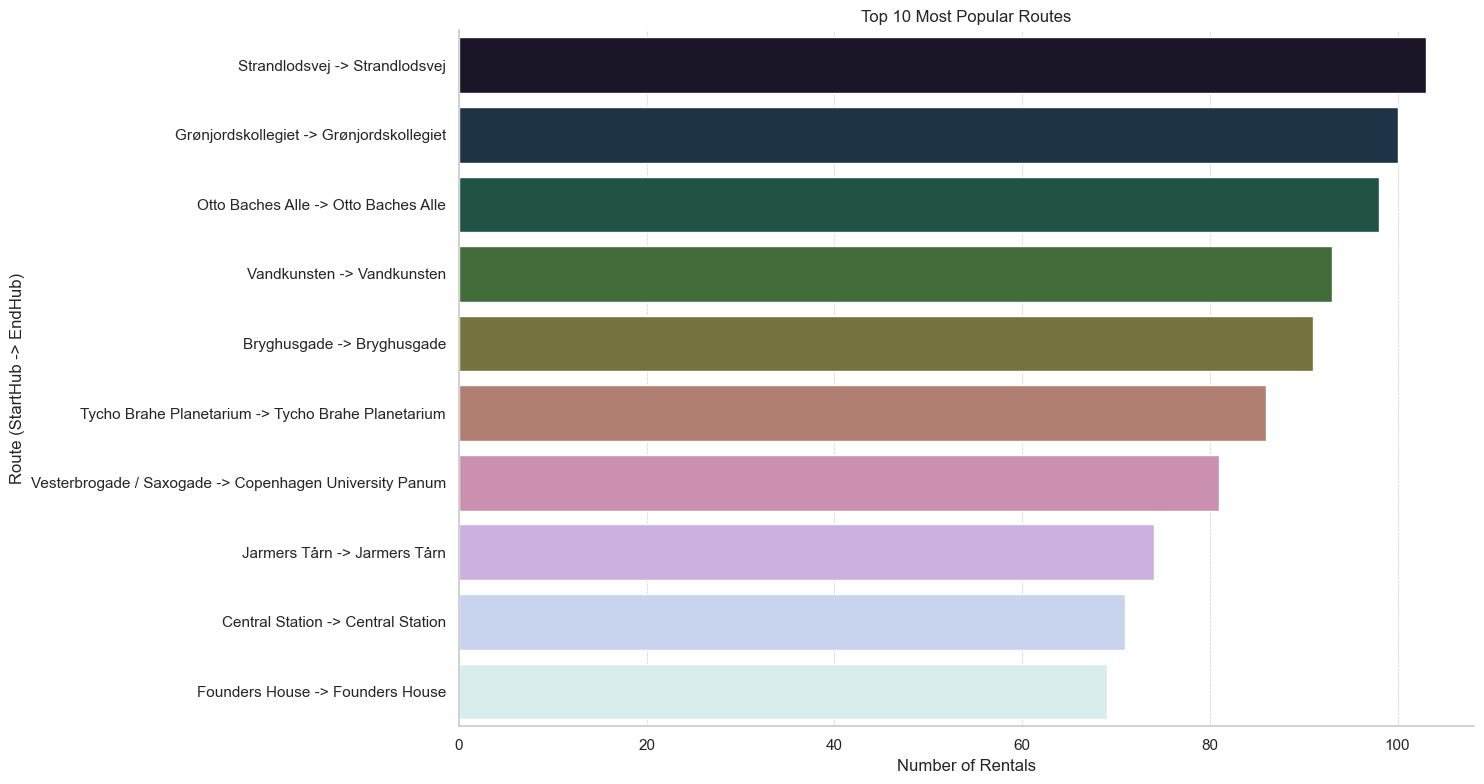

In [ ]:
# Plotting the top 10 most popular routes
plt.figure(figsize=(15, 8))
top_routes_plot = sns.barplot(y=top_routes_series.index, x=top_routes_series.values, palette='cubehelix')
plt.title('Top 10 Most Popular Routes')
plt.xlabel('Number of Rentals')
plt.ylabel('Route (StartHub -> EndHub)')
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout()
sns.despine()
plt.show()


In [ ]:
top_routes

Index(['Strandlodsvej -> Strandlodsvej',
       'Grønjordskollegiet -> Grønjordskollegiet',
       'Otto Baches Alle -> Otto Baches Alle', 'Vandkunsten -> Vandkunsten',
       'Bryghusgade -> Bryghusgade',
       'Tycho Brahe Planetarium -> Tycho Brahe Planetarium',
       'Vesterbrogade / Saxogade -> Copenhagen University Panum',
       'Jarmers Tårn -> Jarmers Tårn', 'Central Station -> Central Station',
       'Founders House -> Founders House'],
      dtype='object', name='Route')

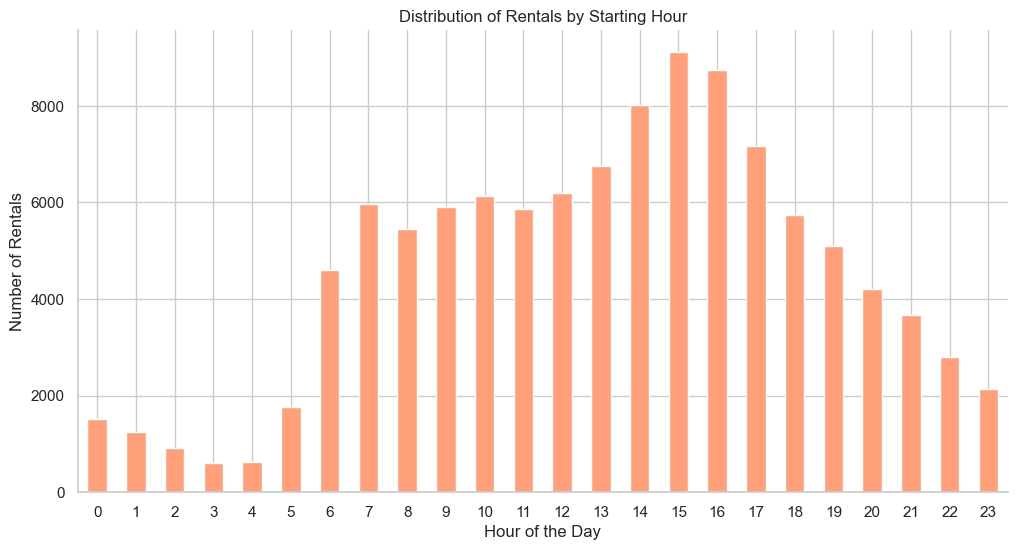

In [ ]:
# Distribution of rentals based on starting hour
hourly_rentals = rentals.groupby('StartHour').size()

plt.figure(figsize=(12, 6))
hourly_rentals.plot(kind='bar', color='lightsalmon')
plt.title('Distribution of Rentals by Starting Hour')
plt.ylabel('Number of Rentals')
plt.xlabel('Hour of the Day')
plt.xticks(rotation=0)
sns.despine()
plt.show()


## Hourly Distribution of Rentals

The bar chart showcases the hourly distribution of rentals:

- **Morning Peak:** There is a noticeable peak around 8-9 AM, which corresponds to typical morning commute times.
- **Afternoon-Early Evening Peak:** Another significant peak is observed between 4-6 PM, aligning with evening commute times.
- **Off-Peak Hours:** The early hours (midnight to 5 AM) see the least activity, which is expected as these are typically non-commute and resting hours.
- **Steady Usage:** Throughout the day, there's steady usage of rentals, with a slight dip in the early afternoon.

These patterns align with what we might expect for a public transport system, where users rent bikes for commuting to work or other daily activities.

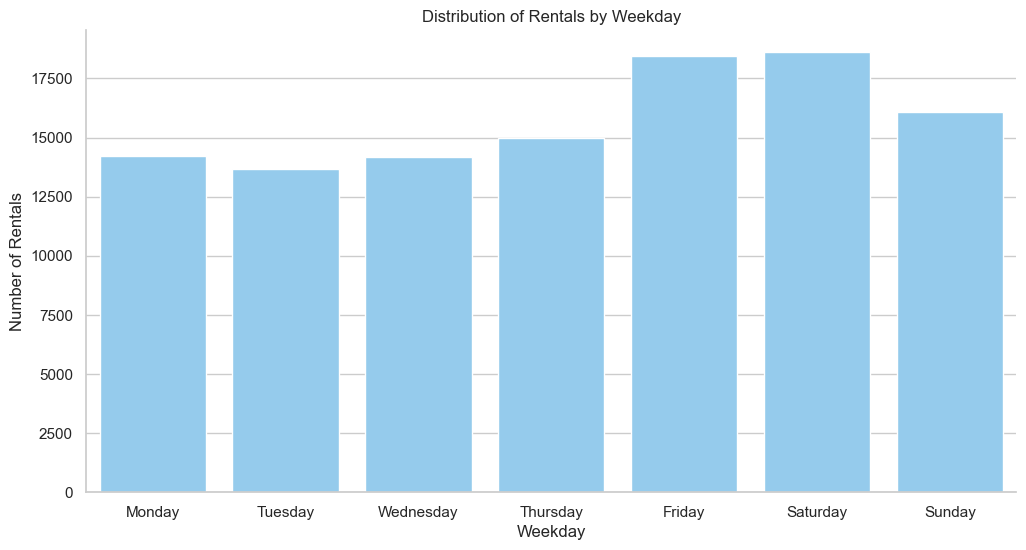

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data = rentals, x = 'Weekday', color='lightskyblue', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Distribution of Rentals by Weekday')
plt.ylabel('Number of Rentals')
plt.xlabel('Weekday')
plt.xticks(rotation=0)
sns.despine()
plt.show()

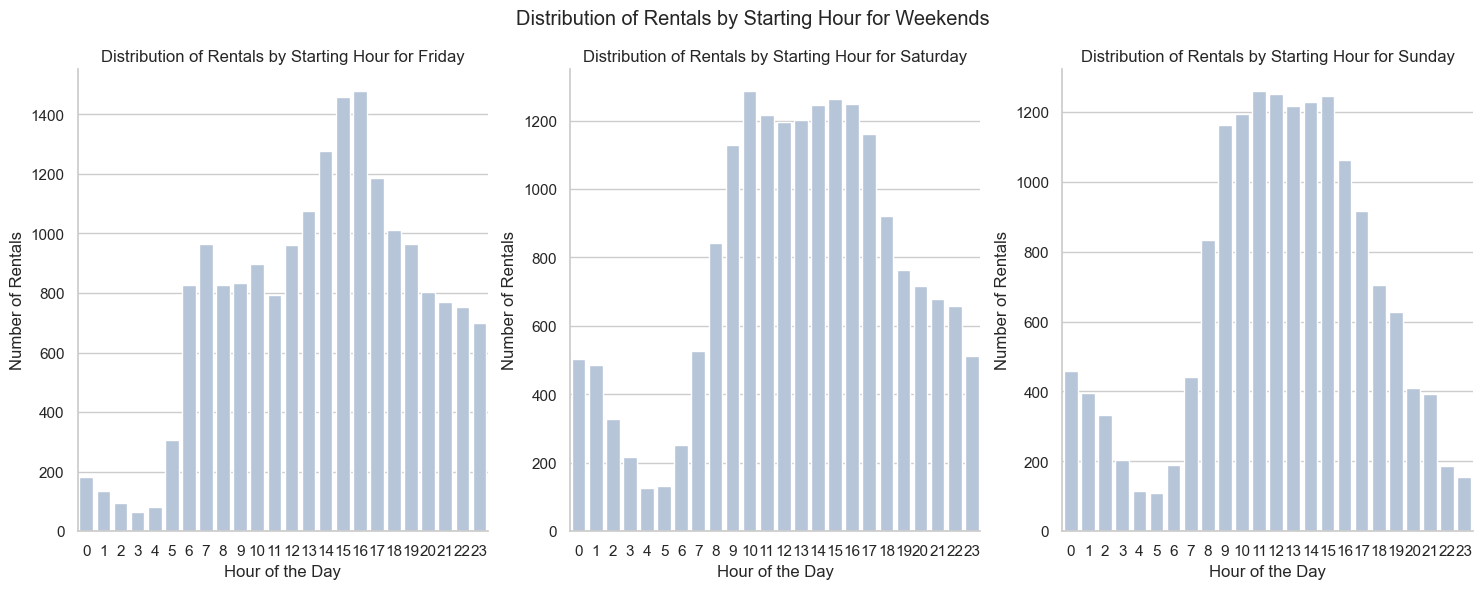

In [ ]:
# for Friday, Saturday, and Sunday explore the hourly distribution
weekend_rentals = rentals[rentals['Weekday'].isin(['Friday', 'Saturday', 'Sunday'])]

weekenddays = ['Friday', 'Saturday', 'Sunday']
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, day in enumerate(weekenddays):
    day_rentals = weekend_rentals[weekend_rentals['Weekday'] == day]
    sns.countplot(data=day_rentals, x='StartHour', color='lightsteelblue', ax=axs[i])
    axs[i].set_title(f'Distribution of Rentals by Starting Hour for {day}')
    axs[i].set_ylabel('Number of Rentals')
    axs[i].set_xlabel('Hour of the Day')
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=0)
    sns.despine()

plt.suptitle('Distribution of Rentals by Starting Hour for Weekends')
plt.show()


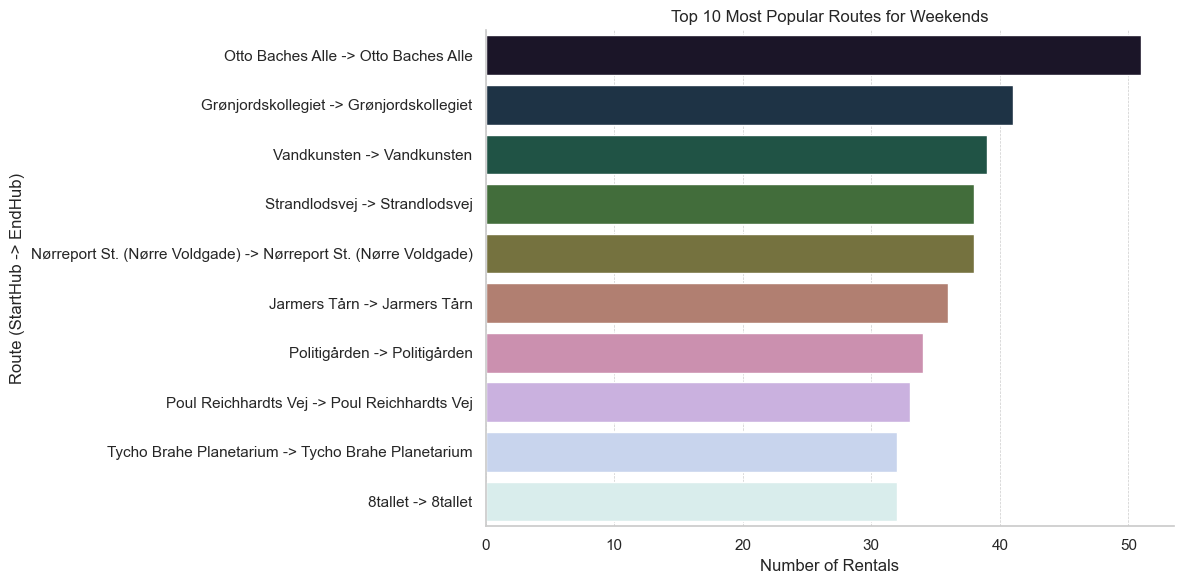

In [ ]:
# PLOT THE 10 TOP ROUTES in the weekend 
# Create a list of the top 10 most popular routes
weekend_top_routes = weekend_rentals['Route'].value_counts().head(10).index
weekend_top_routes_series = weekend_rentals['Route'].value_counts().head(10)

# plot the count of each top route
plt.figure(figsize=(12, 6))
weekend_top_routes_plot = sns.barplot(y=weekend_top_routes_series.index, x=weekend_top_routes_series.values, palette='cubehelix')   
plt.title('Top 10 Most Popular Routes for Weekends')
plt.xlabel('Number of Rentals')
plt.ylabel('Route (StartHub -> EndHub)')
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout()
sns.despine()
plt.show()

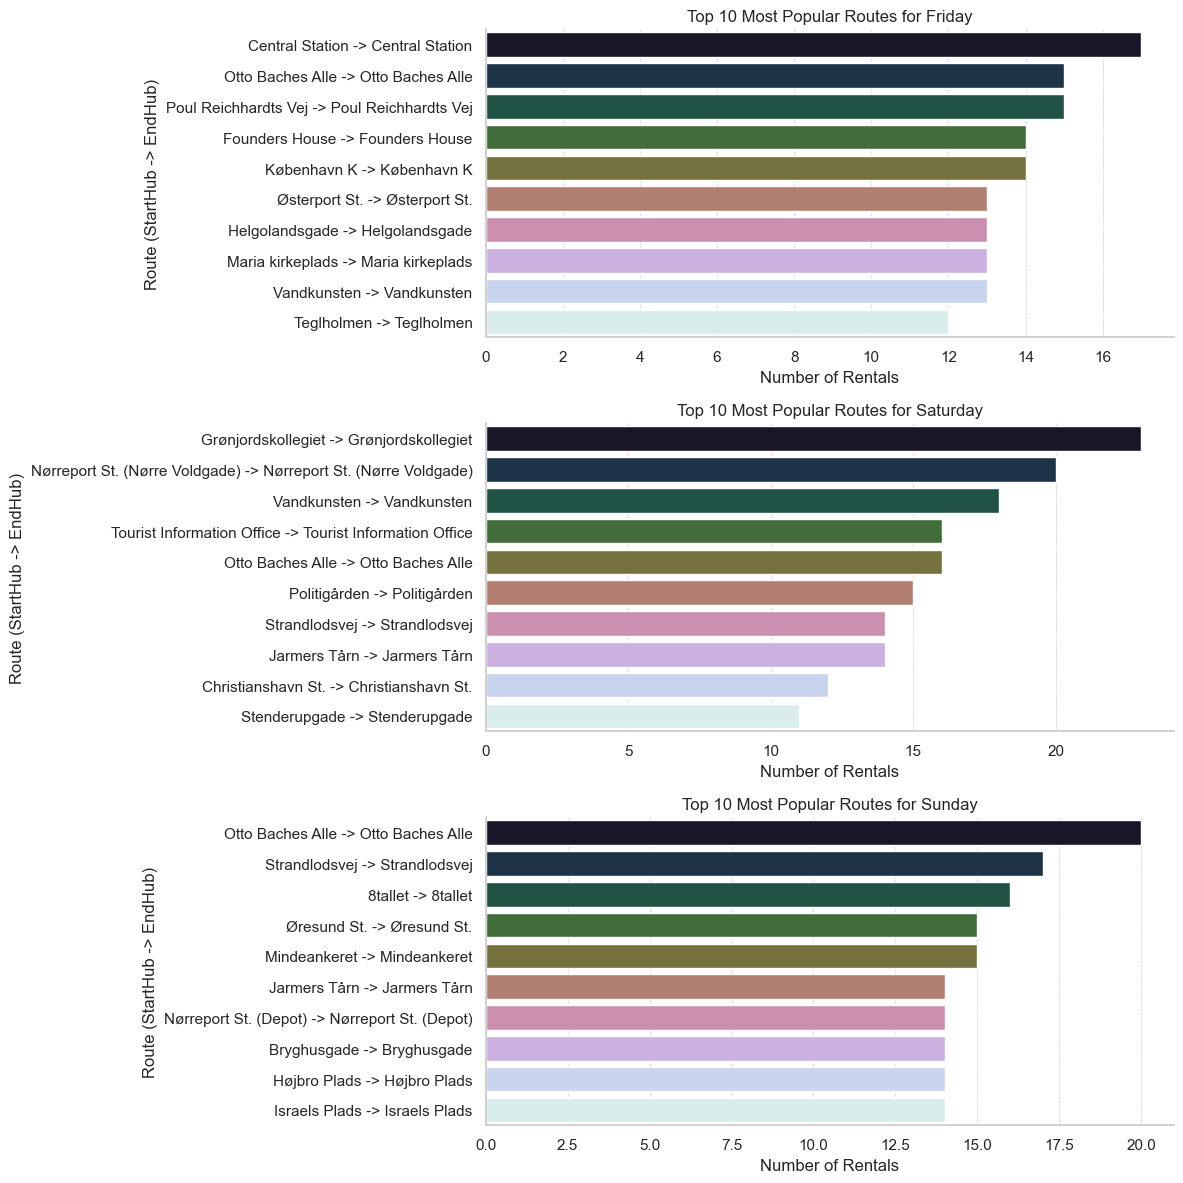

In [ ]:
# Create a list of the top 10 most popular routes for each day of the weekend
weekend_top_routes = {}
for day in ['Friday', 'Saturday', 'Sunday']:
    weekend_top_routes[day] = rentals[rentals['Weekday'] == day]['Route'].value_counts().head(10)

# plot the count of each top route for each day of the weekend
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

for i, day in enumerate(['Friday', 'Saturday', 'Sunday']):
    sns.barplot(y=weekend_top_routes[day].index, x=weekend_top_routes[day].values, palette='cubehelix', ax=axs[i])
    axs[i].set_title(f'Top 10 Most Popular Routes for {day}')
    axs[i].set_xlabel('Number of Rentals')
    axs[i].set_ylabel('Route (StartHub -> EndHub)')
    axs[i].grid(axis='x', linestyle='--', linewidth=0.5)
    sns.despine()

# remove the last subplot
#fig.delaxes(axs[1, 1])
plt.tight_layout()

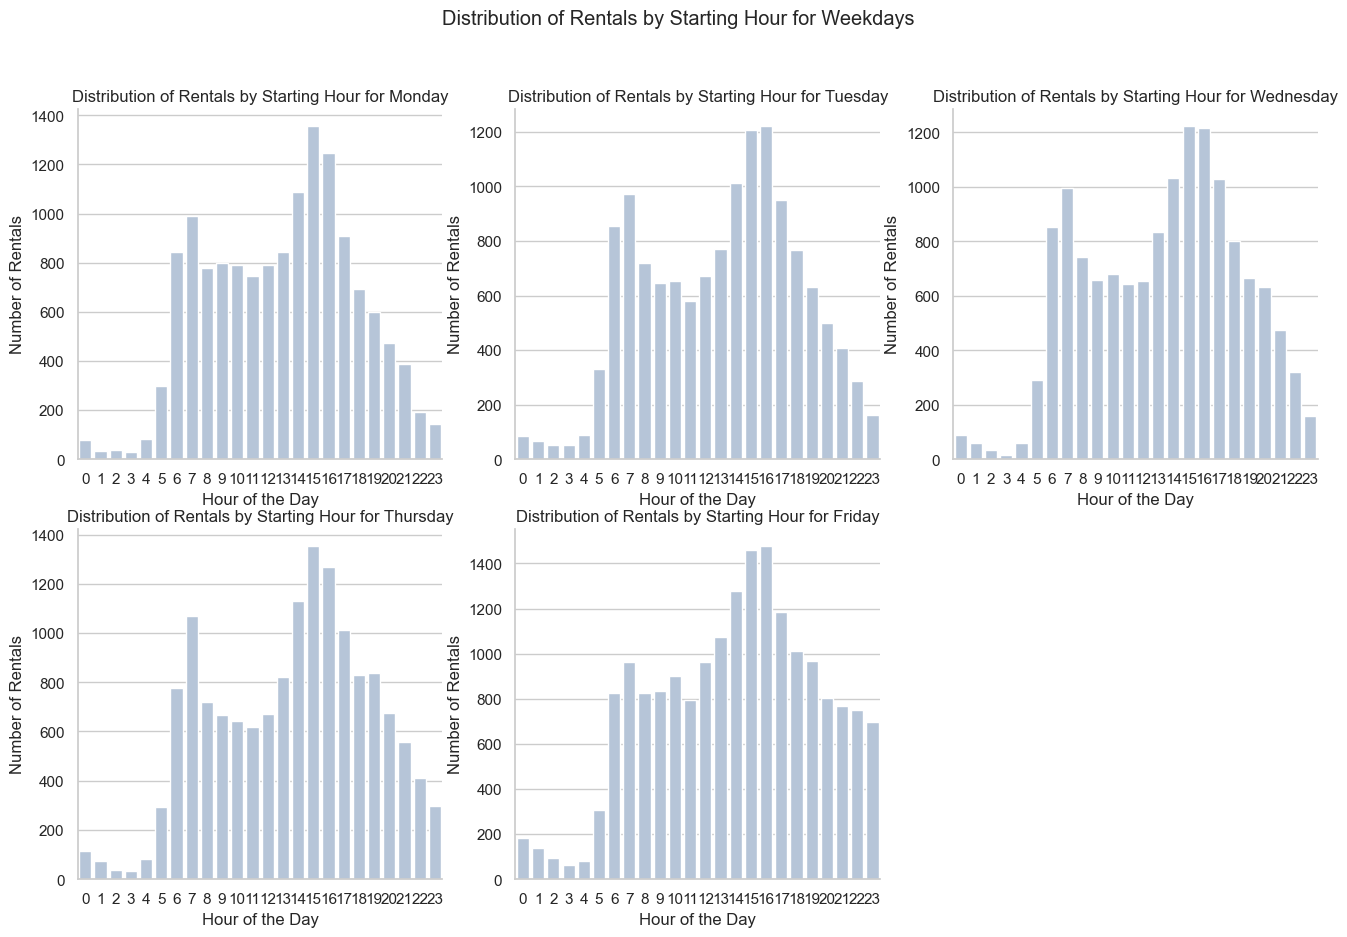

In [ ]:
# for Monday to Friday, explore the hourly distribution
weekday_rentals = rentals[rentals['Weekday'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, day in enumerate(weekdays):
    row = i // 3
    col = i % 3
    day_rentals = weekday_rentals[weekday_rentals['Weekday'] == day]
    sns.countplot(data=day_rentals, x='StartHour', color='lightsteelblue', ax=axs[row, col])
    axs[row, col].set_title(f'Distribution of Rentals by Starting Hour for {day}')
    axs[row, col].set_ylabel('Number of Rentals')
    axs[row, col].set_xlabel('Hour of the Day')
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=0)
    sns.despine()

plt.suptitle('Distribution of Rentals by Starting Hour for Weekdays')
# remove the last subplot
fig.delaxes(axs[1, 2])
plt.show()


In [ ]:
# Group by StartTime date (ignoring the time component) and count the rentals
daily_rentals = rentals.groupby(rentals['StartTime'].dt.date).size()

# Plotly interactive plot for Rentals by Date
fig2 = px.line(daily_rentals.reset_index(), x='StartTime', y=0, 
               labels={'0': 'Number of Rentals', 'StartTime': 'Date'},
               title='Rentals by Date')
fig2.update_xaxes(rangeslider_visible=True, tickmode='linear', dtick='M1')
# set size
fig3.update_layout(width= 1000,height=600)

fig2.show()


In [ ]:
# create a plotly line figure of number of rentals by month but keeping in mind the year as well
rentals['YearMonth'] = rentals['StartTime'].dt.strftime('%Y-%m')
monthly_rentals = rentals.groupby('YearMonth').size()   

fig3 = px.line(monthly_rentals.reset_index(), x='YearMonth', y=0,
                labels={'0': 'Number of Rentals', 'YearMonth': 'Month'},
                title='Rentals by Month', markers= 'lines+markers')
fig3.update_xaxes(rangeslider_visible=True, tickmode='linear', dtick='M1')
# set figure size
fig3.update_layout(width= 1000,height=600)
fig3.show()





In [ ]:
rentals.columns

Index(['StartTime', 'EndTime', 'StartHubId', 'EndHubId', 'UserId',
       'latitudeStart', 'longitudeStart', 'nameStart', 'latitudeEnd',
       'longitudeEnd', 'nameEnd', 'HaversineDistance', 'Month', 'StartHour',
       'Weekday', 'TripDurationMin', 'TripDurationHr', 'SpeedKmHr', 'Route',
       'YearMonth'],
      dtype='object')

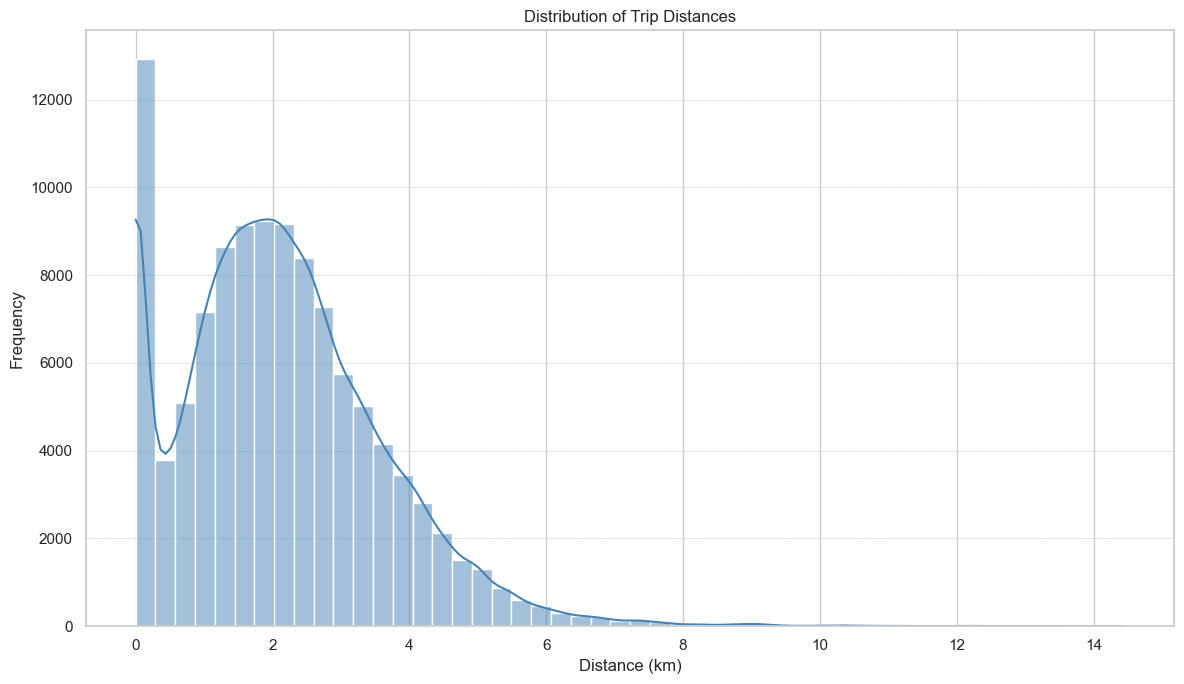

In [ ]:
# Plotting the distribution of trip distances using a histogram
plt.figure(figsize=(12, 7))
sns.histplot(rentals['HaversineDistance'], bins=50, kde=True, color="steelblue")
plt.title('Distribution of Trip Distances')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Short Trips: A significant majority of the trips are short, with distances less than 5 km. This suggests that these rentals are primarily used for short commutes, which aligns with the idea of multimodality in public transport.

Peak around 0 km: There's a noticeable peak close to 0 km. This could indicate that many trips are short round trips, where users return to the starting hub, or it could be indicative of short trips between nearby hubs.

Longer Trips: There are a few trips that extend beyond 10 km, but they are relatively less frequent.

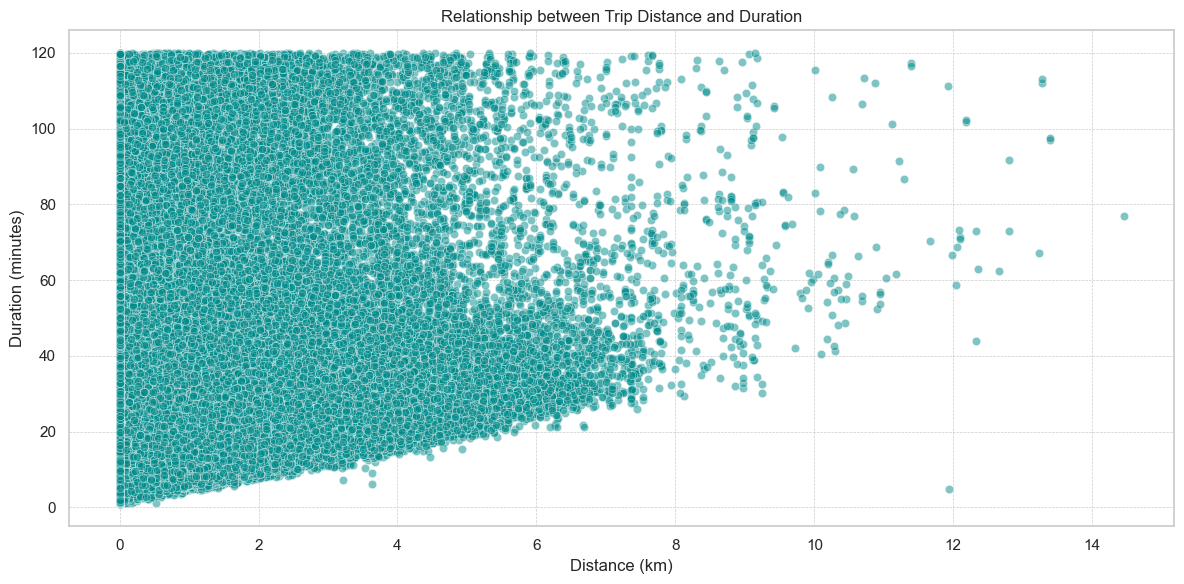

In [ ]:
# Scatter plot to visualize the relationship between trip distance and duration
plt.figure(figsize=(12, 6))
sns.scatterplot(data=rentals, x='HaversineDistance', y='TripDurationMin', alpha=0.5, color="darkcyan")
plt.title('Relationship between Trip Distance and Duration')
plt.xlabel('Distance (km)')
plt.ylabel('Duration (minutes)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Positive Correlation: As expected, there's a general trend indicating that as the trip distance increases, the duration also tends to increase.

Dense Cluster: There's a dense cluster of points in the bottom-left region, indicating many short trips with short durations. This aligns with our earlier observation that most trips are short and are likely used for quick commutes.

Variability: For a given distance, there's variability in trip duration, which could be influenced by factors like traffic, user speed preferences, stops, or detours.

In [ ]:
# load cop_area dataset
cop_area = gpd.read_file('../data/processed/cop_area.shp')

In [ ]:

# load an empty map
##map_1 = KeplerGl(height=600, width=800)
#map_1

In [ ]:
# add data to Kepler map
# map_1.add_data(data=rentals, name='rentals')
# map_1.add_data(data=cop_area, name='cop_area')

In [ ]:
rentals.columns

Index(['StartTime', 'EndTime', 'StartHubId', 'EndHubId', 'UserId',
       'latitudeStart', 'longitudeStart', 'nameStart', 'latitudeEnd',
       'longitudeEnd', 'nameEnd', 'HaversineDistance', 'Month', 'StartHour',
       'Weekday', 'TripDurationMin', 'TripDurationHr', 'SpeedKmHr', 'Route',
       'YearMonth'],
      dtype='object')